In [1]:
import yaml
import numpy as np
import pandas as pd
from pathlib import Path
from scipy import interpolate
import matplotlib.pyplot as plt


In [2]:
class Airfoil:
    @classmethod
    def from_windio_airfoil(cls, airfoil: dict, R: float):
        # print(airfoil["polars"]['configuration'])
        assert len(airfoil["polars"]) == 1

        grid = np.array(airfoil["polars"][0]["c_l"]["grid"])
        return cls(
            airfoil["name"],
            grid,
            airfoil["polars"][0]["c_l"]["values"],
            airfoil["polars"][0]["c_d"]["values"],
        )

    def __init__(self, name, grid, cl, cd):
        self.name = name
        self.Cl_interp = interpolate.interp1d(grid, cl, fill_value="extrapolate")
        self.Cd_interp = interpolate.interp1d(grid, cd, fill_value="extrapolate")

    def __repr__(self):
        return f"Airfoil: {self.name}"

    def Cl(self, angle):
        return self.Cl_interp(angle)

    def Cd(self, angle):
        return self.Cd_interp(angle)


class BladeAirfoils:
    @classmethod
    def from_windio(cls, windio: dict, hub_radius, R, N=200):
        blade = windio["components"]["blade"]
        D = windio["assembly"]["rotor_diameter"]

        # Extract airfoil position grid and labels
        airfoil_grid = np.array(blade["outer_shape_bem"]["airfoil_position"]["grid"])
        airfoil_grid_adjusted = (hub_radius + airfoil_grid * (R - hub_radius)) / R
        airfoil_order = blade["outer_shape_bem"]["airfoil_position"]["labels"]

        # Create airfoil objects
        airfoils = {x["name"]: Airfoil.from_windio_airfoil(x, R) for x in windio["airfoils"]}

        # Return an instance of the class
        return cls(D, airfoil_grid_adjusted, airfoil_order, airfoils, N=N)

    def __init__(self, D, airfoil_grid, airfoil_order, airfoils, N=200):
        self.D = D
        self.airfoil_grid = airfoil_grid  # Store the grid of airfoil positions
        self.airfoil_order = airfoil_order  # Store the order of airfoils
        self.airfoils = airfoils  # Store the dictionary of airfoil objects

        # Generate aerodynamic property interpolations
        aoa_grid = np.linspace(-np.pi, np.pi, N)  # Angle of attack grid
        cl = np.array([airfoils[name].Cl(aoa_grid) for name in airfoil_order])  # Lift coefficients
        cd = np.array([airfoils[name].Cd(aoa_grid) for name in airfoil_order])  # Drag coefficients

        self.cl_interp = interpolate.RectBivariateSpline(airfoil_grid, aoa_grid, cl)
        self.cd_interp = interpolate.RectBivariateSpline(airfoil_grid, aoa_grid, cd)

    def Cl(self, x, inflow):
        return self.cl_interp(x, inflow, grid=False)

    def Cd(self, x, inflow):
        return self.cd_interp(x, inflow, grid=False)

    def __call__(self, x, inflow):
        return self.Cl(x, inflow), self.Cd(x, inflow)



class RotorDefinition:
    @classmethod
    def from_windio(cls, windio: dict):
        name = windio["name"]

        P_rated = windio["assembly"]["rated_power"]
        hub_height = windio["assembly"]["hub_height"]
        rotorspeed_max = windio["control"]["torque"]["VS_maxspd"]
        tsr_target = windio["control"]["torque"]["tsr"]

        hub_diameter = windio["components"]["hub"]["diameter"]
        hub_radius = hub_diameter / 2
        cone = windio["components"]["hub"]["cone_angle"]  # deg
        blade = windio["components"]["blade"]

        blade_length = blade["outer_shape_bem"]["reference_axis"]["z"]["values"][-1]

        N_blades = windio["assembly"]["number_of_blades"]
        D = windio["assembly"]["rotor_diameter"]

        # Rotor radius adjusted to include cone angle and hub diameter
        # R = blade_length * np.cos(np.deg2rad(cone)) + hub_radius
        R = blade_length * np.cos(cone) + hub_radius

        data_twist = blade["outer_shape_bem"]["twist"]
        data_chord = blade["outer_shape_bem"]["chord"]

        # grid including hub center and cone angle
        twist_grid = (hub_radius + np.array(data_twist["grid"]) * (R - hub_radius)) / R
        twist_func = interpolate.interp1d(twist_grid, data_twist["values"], fill_value="extrapolate")
        # grid including hub center and cone angle
        chord_grid = (hub_radius + np.array(data_chord["grid"]) * (R - hub_radius)) / R
        chord_func = interpolate.interp1d(chord_grid, data_chord["values"], fill_value="extrapolate")

        solidity_func = lambda mu: np.minimum(
            N_blades * chord_func(mu) / (2 * np.pi * np.maximum(mu, 0.0001) * R),
            1,
        )

        airfoil_func = BladeAirfoils.from_windio(windio, hub_radius, R)

        return cls(
            twist_func,
            chord_func,
            solidity_func,
            airfoil_func,
            N_blades,
            R,
            P_rated,
            rotorspeed_max,
            hub_height,
            tsr_target,
            hub_radius,
            name=name,
        )

    def __init__(
        self,
        twist_func,
        chord_func,
        solidity_func,
        airfoil_func,
        N_blades,
        R,
        P_rated,
        rotorspeed_max,
        hub_height,
        tsr_target,
        hub_radius,
        name=None,
    ):
        self.name = name
        self.N_blades = N_blades

        self.R = R
        self.P_rated = P_rated
        self.rotorspeed_max = rotorspeed_max
        self.hub_height = hub_height
        self.tsr_target = tsr_target
        self.hub_radius = hub_radius

        self.twist_func = twist_func
        self.chord_func = chord_func
        self.solidity_func = solidity_func
        self.airfoil_func = airfoil_func

    def twist(self, mu):
        return self.twist_func(mu)

    def solidity(self, mu):
        return self.solidity_func(mu)

    def clcd(self, mu, aoa):
        return self.airfoil_func(mu, aoa)


In [3]:
def evaluate_properties_vector_nearest(mu_vector, rotor_definition):
    # Evaluate twist and chord directly using vectorized functions
    twist_angles = rotor_definition.twist_func(mu_vector)
    chord_lengths = rotor_definition.chord_func(mu_vector)

    # Retrieve the airfoil grid and order from the rotor_definition
    airfoil_grid = rotor_definition.airfoil_func.airfoil_grid  # Get the grid of mu values
    airfoil_order = rotor_definition.airfoil_func.airfoil_order  # Airfoil names from the input

    # Compute distances from each mu to the airfoil grid
    distances = np.abs(mu_vector[:, None] - airfoil_grid[None, :])
    nearest_indices = np.argmin(distances, axis=1)  # Find the nearest grid index for each mu

    # Map nearest indices to airfoil names
    airfoil_names = np.array(airfoil_order)[nearest_indices]

    # Return vectors for all quantities
    return twist_angles, chord_lengths, airfoil_names, nearest_indices

In [4]:
turbine = '/Users/stormmata/Library/Mobile Documents/com~apple~CloudDocs/Courses/Research/Code/MITRotor/MITRotor/ReferenceTurbines/IEA-15-240-RWT.yaml'
# turbine = '/Users/stormmata/Library/Mobile Documents/com~apple~CloudDocs/Courses/Research/Code/MITRotor/MITRotor/ReferenceTurbines/IEA-22-280-RWT.yaml'

In [5]:
with open(turbine, "r") as f:
    data = yaml.safe_load(f)

rotor_definition = RotorDefinition.from_windio(data)

In [6]:
mu_vector1 = np.arange(0.0, 0.20, 0.01)  # 100 points from 0 to 1
mu_vector2 = np.arange(0.20, 0.90, 0.02)  # 100 points from 0 to 1
mu_vector3 = np.arange(0.90, 0.95, 0.01)  # 100 points from 0 to 1
mu_vector4 = np.arange(0.95, 1.005, 0.005)  # 100 points from 0 to 1
mu_vector  = np.concatenate((mu_vector1,mu_vector2,mu_vector3,mu_vector4))
mu_vector


array([0.   , 0.01 , 0.02 , 0.03 , 0.04 , 0.05 , 0.06 , 0.07 , 0.08 ,
       0.09 , 0.1  , 0.11 , 0.12 , 0.13 , 0.14 , 0.15 , 0.16 , 0.17 ,
       0.18 , 0.19 , 0.2  , 0.22 , 0.24 , 0.26 , 0.28 , 0.3  , 0.32 ,
       0.34 , 0.36 , 0.38 , 0.4  , 0.42 , 0.44 , 0.46 , 0.48 , 0.5  ,
       0.52 , 0.54 , 0.56 , 0.58 , 0.6  , 0.62 , 0.64 , 0.66 , 0.68 ,
       0.7  , 0.72 , 0.74 , 0.76 , 0.78 , 0.8  , 0.82 , 0.84 , 0.86 ,
       0.88 , 0.9  , 0.91 , 0.92 , 0.93 , 0.94 , 0.95 , 0.955, 0.96 ,
       0.965, 0.97 , 0.975, 0.98 , 0.985, 0.99 , 0.995, 1.   ])

In [192]:
mu_vector * rotor_definition.R

array([  0.        ,   1.20684994,   2.41369988,   3.62054982,
         4.82739976,   6.03424969,   7.24109963,   8.44794957,
         9.65479951,  10.86164945,  12.06849939,  13.27534933,
        14.48219927,  15.6890492 ,  16.89589914,  18.10274908,
        19.30959902,  20.51644896,  21.7232989 ,  22.93014884,
        24.13699878,  26.55069865,  28.96439853,  31.37809841,
        33.79179829,  36.20549816,  38.61919804,  41.03289792,
        43.4465978 ,  45.86029767,  48.27399755,  50.68769743,
        53.10139731,  55.51509718,  57.92879706,  60.34249694,
        62.75619682,  65.1698967 ,  67.58359657,  69.99729645,
        72.41099633,  74.82469621,  77.23839608,  79.65209596,
        82.06579584,  84.47949572,  86.89319559,  89.30689547,
        91.72059535,  94.13429523,  96.5479951 ,  98.96169498,
       101.37539486, 103.78909474, 106.20279461, 108.61649449,
       109.82334443, 111.03019437, 112.23704431, 113.44389425,
       114.65074419, 115.25416916, 115.85759413, 116.46

In [7]:
twist_angles, chord_lengths, airfoil_names, airfoil_indices = evaluate_properties_vector_nearest(mu_vector, rotor_definition)

In [8]:
airfoil_indices[airfoil_indices == 0] = 1
airfoil_indices[airfoil_indices == 9] = 8

airfoil_names = np.char.add(np.char.add('"', airfoil_names), '"')

In [204]:
# Combine arrays into a dictionary or a list of lists for DataFrame
data = {
    'R': mu_vector * rotor_definition.R,
    'chord': chord_lengths,
    'thickness': np.zeros_like(chord_lengths), 
    'twist': twist_angles * 180/np.pi,
    'airfoil': airfoil_names, 
    'ID': airfoil_indices
}

# Convert dictionary to DataFrame
df = pd.DataFrame(data)

# Save to CSV file
df.to_csv('/Users/stormmata/Downloads/15MW_values_from_yaml.csv', index=False)

In [53]:
import os

def save_airfoil_tables(blade_airfoils, output_dir="airfoil_tables", N_aoa=181):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Generate an angle of attack grid
    aoa_grid = np.linspace(-np.pi, np.pi, N_aoa)

    # Loop through each airfoil
    for airfoil_name, airfoil_obj in blade_airfoils.airfoils.items():
        # Get lift (Cl) and drag (Cd) for the angle of attack grid
        Cl_values = airfoil_obj.Cl(aoa_grid)
        Cd_values = airfoil_obj.Cd(aoa_grid)

        # Create a DataFrame with angle of attack, lift, and drag
        data = {
            "Angle of Attack (rad)": aoa_grid * 180/np.pi,
            "Lift Coefficient (Cl)": Cl_values,
            "Drag Coefficient (Cd)": Cd_values,
        }
        df = pd.DataFrame(data)

        # Save the table to a CSV file named after the airfoil
        output_file = os.path.join(output_dir, f"{airfoil_name}_aero_table.csv")
        df.to_csv(output_file, index=False, float_format="%.6f")

        print(f"Saved {airfoil_name} table to {output_file}")

# Example usage
save_airfoil_tables(rotor_definition.airfoil_func)

Saved FFA-W3-211 table to airfoil_tables/FFA-W3-211_aero_table.csv
Saved FFA-W3-241 table to airfoil_tables/FFA-W3-241_aero_table.csv
Saved FFA-W3-270blend table to airfoil_tables/FFA-W3-270blend_aero_table.csv
Saved FFA-W3-301 table to airfoil_tables/FFA-W3-301_aero_table.csv
Saved FFA-W3-330blend table to airfoil_tables/FFA-W3-330blend_aero_table.csv
Saved FFA-W3-360 table to airfoil_tables/FFA-W3-360_aero_table.csv
Saved SNL-FFA-W3-420FB table to airfoil_tables/SNL-FFA-W3-420FB_aero_table.csv
Saved SNL-FFA-W3-480FB table to airfoil_tables/SNL-FFA-W3-480FB_aero_table.csv
Saved SNL-FFA-W3-560FB table to airfoil_tables/SNL-FFA-W3-560FB_aero_table.csv
Saved FB60 table to airfoil_tables/FB60_aero_table.csv
Saved FB70 table to airfoil_tables/FB70_aero_table.csv
Saved FB80 table to airfoil_tables/FB80_aero_table.csv
Saved FB90 table to airfoil_tables/FB90_aero_table.csv
Saved circular table to airfoil_tables/circular_aero_table.csv


Text(0.5, 0, 'Radial position, $r/R$ [-]')

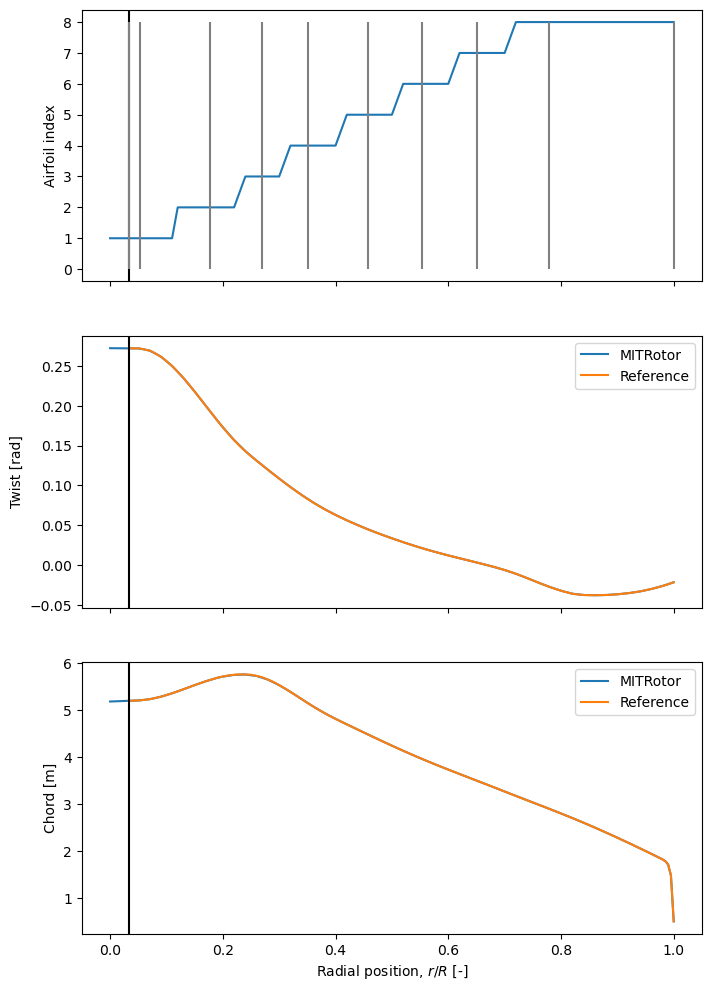

In [9]:
roverR_CT = (rotor_definition.hub_radius + np.array([0.00000000,0.02040816,0.04081633,0.06122449,0.08163265,0.10204082,0.12244898,0.14285714,0.16326531,0.18367347,0.20408163,0.22448980,0.24489796,0.26530612,0.28571429,0.30612245,0.32653061,0.34693878,0.36734694,0.38775510,0.40816327,0.42857143,0.44897959,0.46938776,0.48979592,0.51020408,0.53061224,0.55102041,0.57142857,0.59183673,0.61224490,0.63265306,0.65306122,0.67346939,0.69387755,0.71428571,0.73469388,0.75510204,0.77551020,0.79591837,0.81632653,0.83673469,0.85714286,0.87755102,0.89795918,0.91836735,0.93877551,0.95918367,0.97959184,0.98500000,0.99000000,0.99500000,1.00000000]) * (rotor_definition.R - rotor_definition.hub_radius)) / rotor_definition.R
chord     = np.array([5.2000000,5.2088399,5.2378871,5.2933253,5.3673399,5.4520927,5.5400317,5.6218243,5.6925312,5.7426109,5.7648368,5.7561195,5.7030985,5.6046760,5.4715591,5.3227780,5.1664823,5.0194213,4.8858079,4.7679597,4.6545661,4.5410311,4.4281756,4.3169589,4.2078807,4.1016462,3.9987123,3.8994087,3.8031725,3.7093895,3.6171117,3.5256349,3.4340827,3.3419331,3.2486784,3.1561097,3.0645800,2.9729926,2.8807051,2.7869694,2.6910309,2.5919656,2.4893236,2.3839172,2.2759238,2.1654667,2.0526251,1.9377533,1.8196630,1.7799217,1.7077872,1.4724827,0.5000000])
twist     = np.array([0.2721763,0.2720574,0.2689698,0.2609015,0.2488570,0.2338242,0.2168051,0.1988728,0.1810077,0.1641308,0.1492522,0.1367143,0.1255128,0.1143475,0.1035678,0.0933069,0.0837118,0.0749897,0.0671420,0.0601326,0.0537023,0.0477097,0.0421014,0.0368560,0.0319115,0.0272059,0.0227318,0.0185778,0.0147209,0.0111101,0.0076276,0.0041828,0.0006925,-0.0030164,-0.0071050,-0.0118748,-0.0174410,-0.0230475,-0.0283319,-0.0328884,-0.0364116,-0.0377689,-0.0379756,-0.0376171,-0.0367027,-0.0352278,-0.0331044,-0.0300952,-0.0263217,-0.0251846,-0.0240762,-0.0229102,-0.0216838])

airfoil_r = (rotor_definition.hub_radius + np.array([0.0, 0.02, 0.15, 0.24517031675566095, 0.3288439506472435, 0.4391793464459161, 0.5376714071084352, 0.6382076569163737, 0.7717438522715817, 1.0]) * (rotor_definition.R - rotor_definition.hub_radius)) / rotor_definition.R

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8, 12), sharex=True)

ax[0].plot(mu_vector, airfoil_indices)
ax[0].axvline(rotor_definition.hub_radius/rotor_definition.R,color='k')
ax[0].vlines(airfoil_r,0,8,color='grey')
ax[0].set_ylabel('Airfoil index')
ax[1].plot(mu_vector, twist_angles, label='MITRotor')
ax[1].plot(roverR_CT, twist, label='Reference')
ax[1].axvline(rotor_definition.hub_radius/rotor_definition.R,color='k')
ax[1].legend()
ax[1].set_ylabel('Twist [rad]')
ax[2].plot(mu_vector, chord_lengths, label='MITRotor')
ax[2].plot(roverR_CT, chord, label='Reference')
ax[2].axvline(rotor_definition.hub_radius/rotor_definition.R,color='k')
ax[2].legend()
ax[2].set_ylabel('Chord [m]')
ax[2].set_xlabel('Radial position, $r/R$ [-]')


In [216]:
rotor_definition.hub_radius*2

7.94

In [51]:
D = 199
veer    = np.arange(-0.3,0.35,0.05)
veer[6] = 0.0
# shear   = np.zeros_like(veer)
shear    = [0]
shear

[0]

In [52]:
import itertools
# Create all combinations
combinations = list(itertools.product(shear, np.round(veer*100,1)))

formatted_combinations = [f"r's{pair[0]}_v{pair[1]}'" for pair in combinations]
casename_string = [
    rf"s{str(pair[0]).replace('.', '').replace('-', 'n')}_v{str(pair[1]).split('.')[0].replace('-', 'n')}" 
    for pair in combinations
]
casename_string

['s0_vn30',
 's0_vn25',
 's0_vn20',
 's0_vn15',
 's0_vn10',
 's0_vn5',
 's0_v0',
 's0_v5',
 's0_v10',
 's0_v15',
 's0_v20',
 's0_v25',
 's0_v30']

In [40]:
vinflow = -1.0 * np.ones_like(veer)
a = veer * D * np.pi / 180

In [41]:
vinflow

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])

In [42]:
a

array([-1.04196156, -0.8683013 , -0.69464104, -0.52098078, -0.34732052,
       -0.17366026,  0.        ,  0.17366026,  0.34732052,  0.52098078,
        0.69464104,  0.8683013 ,  1.04196156])

In [50]:
# Create all combinations
combinations = list(itertools.product(shear, np.round(veer * 100, 1)))

# Generate case names with decimal and trailing zero removed
casename = [
    rf"s{str(pair[0]).replace('.', '').replace('-', 'n')}_v{str(pair[1]).split('.')[0].replace('-', 'n')}" 
    for pair in combinations
]
casename

['s00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_v

In [46]:
casename[0]

's0_vn30'

In [49]:
veer    = np.arange(-0.3,0.35,0.05)
veer[6] = 0.0
shear   = np.zeros_like(veer)

# Create all combinations
combinations = list(itertools.product(shear, np.round(veer*100,1)))

casename = [
    rf"s{str(pair[0]).replace('.', '').replace('-', 'n')}_v{str(pair[1]).split('.')[0].replace('-', 'n')}" 
    for pair in combinations
]

casename

['s00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_vn15',
 's00_vn10',
 's00_vn5',
 's00_v0',
 's00_v5',
 's00_v10',
 's00_v15',
 's00_v20',
 's00_v25',
 's00_v30',
 's00_vn30',
 's00_vn25',
 's00_vn20',
 's00_v